In [ ]:
!python --version

Python 3.7.11


In [2]:
pip install scikit-survival

     |████████████████████████████████| 2.4 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 46.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061679 sha256=d1a698b5aa61ae72375c903ed9297aafda89d35468dcf094aef8e389df89861d
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


In [3]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

Text(0.5, 0, 'time $t$')

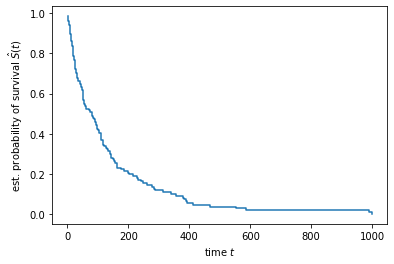

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [28]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

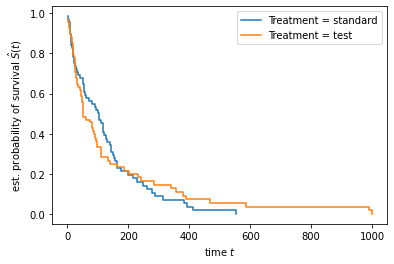

In [31]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

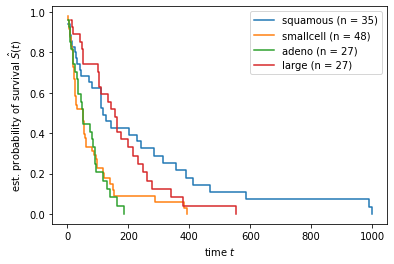

In [32]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [33]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [34]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [35]:
import pandas as pd
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [37]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


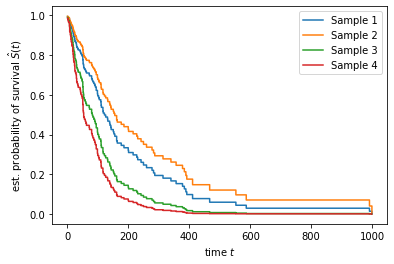

In [38]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [39]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


In [ ]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64

# Random Survival Forest

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [5]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt = np.column_stack((Xt.values, grade_num))

feature_names = X_no_grade.columns.tolist() + ["tgrade"]

In [ ]:
feature_names

['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tsize', 'tgrade']

In [8]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [ ]:
y_train

array([(False, 2009.), (False, 2233.), ( True,  308.), (False,  429.),
       ( True, 1684.), (False, 1114.), ( True,  375.), ( True,  797.),
       (False,  296.), (False,  768.), (False, 2065.), (False,  758.),
       ( True,  348.), (False, 1443.), ( True, 1388.), (False, 2177.),
       (False, 2659.), (False, 1331.), (False, 2132.), (False, 1833.),
       ( True, 1162.), (False, 1342.), ( True,  169.), ( True,  369.),
       ( True,  503.), ( True,  622.), (False, 1984.), ( True, 1493.),
       (False,  723.), (False,  310.), (False, 1502.), (False,  828.),
       (False, 1743.), ( True,  504.), (False, 1091.), (False,  553.),
       (False, 1351.), (False, 1789.), ( True,  370.), (False, 1856.),
       ( True,  195.), (False, 1722.), ( True,  836.), ( True, 1193.),
       ( True,  160.), (False, 2551.), ( True,  552.), (False,  986.),
       (False, 1926.), ( True,  547.), (False, 2467.), ( True,  171.),
       (False, 1349.), (False, 2153.), (False,  615.), (False, 2156.),
      

In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)


In [ ]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [ ]:
rsf.score(X_test, y_test)

0.6759696016771488

HF

In [7]:
df=pd.read_csv('hf.csv')
df

,Age,anaemia,CPK,diabetes,Ejection Fraction,high_blood_pressure,Platelets,Serum Creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [9]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)


In [10]:
x=df.iloc[:,:-2]
x

,Age,anaemia,CPK,diabetes,Ejection Fraction,high_blood_pressure,Platelets,Serum Creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1


In [11]:
y=df.iloc[:,-2:]
y

,time,DEATH_EVENT
0,4,1
1,6,1
2,7,1
3,7,1
4,8,1
...,...,...
294,270,0
295,271,0
296,278,0
297,280,0


In [12]:
yy=pd.concat([y.DEATH_EVENT,y.time],axis=1)

In [13]:
yy

,DEATH_EVENT,time
0,1,4
1,1,6
2,1,7
3,1,7
4,1,8
...,...,...
294,0,270
295,0,271
296,0,278
297,0,280


In [14]:
yy.to_numpy()

array([[  1,   4],
       [  1,   6],
       [  1,   7],
       [  1,   7],
       [  1,   8],
       [  1,   8],
       [  1,  10],
       [  1,  10],
       [  1,  10],
       [  1,  10],
       [  1,  10],
       [  1,  10],
       [  1,  11],
       [  1,  11],
       [  0,  12],
       [  1,  13],
       [  1,  14],
       [  1,  14],
       [  1,  15],
       [  1,  15],
       [  0,  16],
       [  1,  20],
       [  1,  20],
       [  0,  22],
       [  1,  23],
       [  1,  23],
       [  1,  24],
       [  1,  26],
       [  1,  26],
       [  1,  26],
       [  1,  27],
       [  1,  28],
       [  1,  28],
       [  0,  29],
       [  1,  29],
       [  1,  30],
       [  1,  30],
       [  1,  30],
       [  0,  30],
       [  1,  30],
       [  1,  31],
       [  1,  32],
       [  1,  33],
       [  0,  33],
       [  1,  33],
       [  1,  35],
       [  1,  38],
       [  1,  40],
       [  1,  41],
       [  1,  42],
       [  1,  43],
       [  1,  43],
       [  1,

In [15]:
 yy.DEATH_EVENT >0

0       True
1       True
2       True
3       True
4       True
       ...  
294    False
295    False
296    False
297    False
298    False
Name: DEATH_EVENT, Length: 299, dtype: bool

In [16]:
yyy =pd.concat([yy.DEATH_EVENT>0,yy.time],axis=1)
yyy

,DEATH_EVENT,time
0,True,4
1,True,6
2,True,7
3,True,7
4,True,8
...,...,...
294,False,270
295,False,271
296,False,278
297,False,280


In [ ]:
list(map(tuple,yyy.to_numpy()))

In [ ]:
y4=list(map(tuple,yyy.to_numpy()))

In [ ]:
y4

In [17]:
from sksurv.util import Surv


In [18]:
z= Surv.from_dataframe(event= 'DEATH_EVENT',time= 'time', data=yyy)

In [19]:
rsf.fit(x.to_numpy(),z)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [20]:
rsf.score(x.to_numpy(),z)

0.8052434456928839

In [23]:
rsf.n_features_

11

In [42]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(x.to_numpy(),z)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [43]:
estimator.score(x.to_numpy(),z)

0.7405166618649764

In [44]:
coe=pd.Series(estimator.coef_, index=x.columns)

In [45]:
coe

Age                    4.618607e-02
anaemia                4.552595e-01
CPK                    2.209425e-04
diabetes               1.372955e-01
Ejection Fraction     -4.883798e-02
high_blood_pressure    4.719002e-01
Platelets             -5.159760e-07
Serum Creatinine       3.115404e-01
serum_sodium          -4.441268e-02
sex                   -2.398795e-01
smoking                1.185694e-01
dtype: float64

In [ ]:
np.exp(coe.values)

array([1.04726925, 1.5765824 , 1.00022097, 1.14716706, 0.95233542,
       1.6030374 , 0.99999948, 1.3655269 , 0.95655912, 0.78672262,
       1.12588499])

In [ ]:
estimator.cum_baseline_hazard_

StepFunction(x=array([  4.,   6.,   7.,   8.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        20.,  22.,  23.,  24.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  35.,  38.,  40.,  41.,  42.,  43.,  44.,  45.,  50.,  54.,
        55.,  59.,  60.,  61.,  63.,  64.,  65.,  66.,  67.,  68.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  82.,  83.,
        85.,  86.,  87.,  88.,  90.,  91.,  94.,  95.,  96.,  97., 100.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 115.,
       117., 118., 119., 120., 121., 123., 126., 129., 130., 134., 135.,
       140., 145., 146., 147., 148., 150., 154., 162., 170., 171., 172.,
       174., 175., 180., 185., 186., 187., 188., 192., 193., 194., 195.,
       196., 197., 198., 200., 201., 205., 206., 207., 208., 209., 210.,
       211., 212., 213., 214., 215., 216., 220., 230., 231., 233., 235.,
       237., 240., 241., 244., 245., 246., 247., 250., 256., 257., 258.,
       270., 271., 278., 280., 285.]

In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 7.5 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(x.to_numpy(),z)
eli5.show_weights(perm, feature_names=x.columns.tolist())

Weight,Feature
0.0958 ± 0.0298,Serum Creatinine
0.0776 ± 0.0258,Ejection Fraction
0.0529 ± 0.0175,Age
0.0111 ± 0.0033,Platelets
0.0101 ± 0.0034,CPK
0.0082 ± 0.0063,high_blood_pressure
0.0060 ± 0.0068,serum_sodium
0.0046 ± 0.0040,anaemia
0.0024 ± 0.0011,diabetes
0.0024 ± 0.0013,smoking


In [ ]:
x.columns.tolist()

['Age',
 'anaemia',
 'CPK',
 'diabetes',
 'Ejection Fraction',
 'high_blood_pressure',
 'Platelets',
 'Serum Creatinine',
 'serum_sodium',
 'sex',
 'smoking']

In [47]:
pip install lifelines

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=08c0a25564212f5ec19ddeb25f98266913a81dafd268a4eac90dde64cd3f2c13
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [49]:
from lifelines import CoxPHFitter

In [50]:
cox=CoxPHFitter()
cox.fit(df, duration_col='time',event_col='DEATH_EVENT')

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>

In [54]:
cox.score(df)

-1.5659794900468385

In [57]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2021-08-23 15:50:04 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
Age                   0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia               0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
CPK                   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes              0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
Ejection Fraction    -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure   0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
Platelets            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Serum Creatinine      0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium         -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                  -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking               0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                        z      p   -log2(p)
covariate                                  
Age                  4.98 <0.005      20.56
anaemia              2.12   0.03       4.89
CPK                  2.23   0.03       5.26
diabetes             0.63   0.53       0.91
Ejection Fraction   -4.67 <0.005      18.35
high_blood_pressure  2.20   0.03       5.17
Platelets           -0.41   0.68       0.56
Serum Creatinine     4.58 <0.005      17.68
serum_sodium        -1.90   0.06       4.12
sex                 -0.94   0.35       1.53
smoking              0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

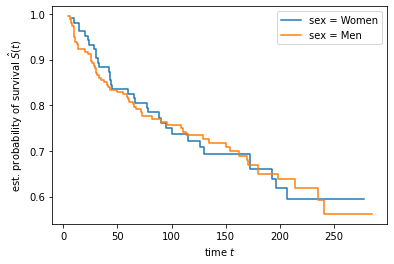

In [76]:
 %matplotlib inline
for treatment_type in (0,1):
    mask_treat = df["sex"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        yyy["DEATH_EVENT"][mask_treat], df["time"][mask_treat]
        )
    if treatment_type==0:
      type = 'Women'
    else:
      type = 'Men'
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="sex = %s" % type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.savefig('sex.jpg',dpi=1200)

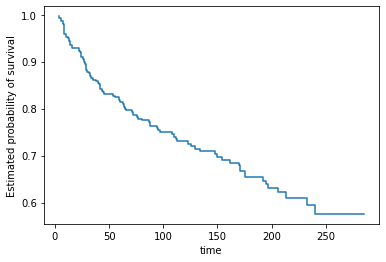

In [79]:
time, surv = kaplan_meier_estimator( yyy['DEATH_EVENT'],yyy['time'])
plt.step(time,surv)
plt.xlabel("time")
plt.ylabel("Estimated probability of survival")
plt.savefig('kaplan.jpg',dpi=1200)

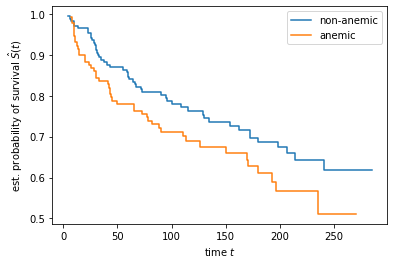

In [81]:
for treatment_type in (0,1):
    mask_treat = df["anaemia"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        yyy["DEATH_EVENT"][mask_treat], df["time"][mask_treat]
        )
    if treatment_type==0:
      type = 'non-anemic'
    else:
      type = 'anemic'
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="%s" % type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.savefig('anemia.jpg',dpi=1200)

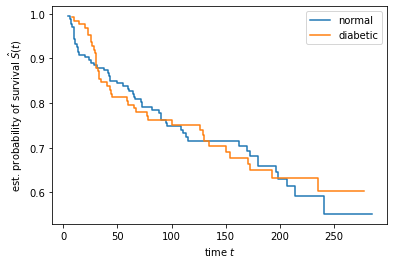

In [82]:
for treatment_type in (0,1):
    mask_treat = df["diabetes"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        yyy["DEATH_EVENT"][mask_treat], df["time"][mask_treat]
        )
    if treatment_type==0:
      type = 'normal'
    else:
      type = 'diabetic'
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="%s" % type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.savefig('diabetes.jpg',dpi=1200)

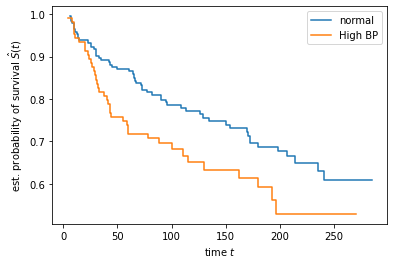

In [83]:
for treatment_type in (0,1):
    mask_treat = df["high_blood_pressure"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        yyy["DEATH_EVENT"][mask_treat], df["time"][mask_treat]
        )
    if treatment_type==0:
      type = 'normal'
    else:
      type = 'High BP'
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="%s" % type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.savefig('bp.jpg',dpi=1200)

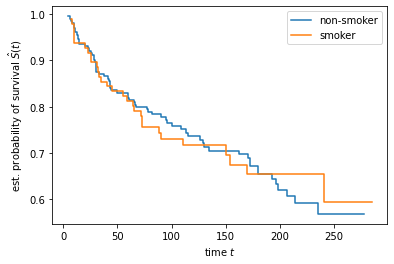

In [85]:
for treatment_type in (0,1):
    mask_treat = df["smoking"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        yyy["DEATH_EVENT"][mask_treat], df["time"][mask_treat]
        )
    if treatment_type==0:
      type = 'non-smoker'
    else:
      type = 'smoker'
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="%s" % type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.savefig('smoker.jpg',dpi=1200)